In [9]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

In [10]:
import sys
import gzip
import shutil

if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read()) 

In [21]:
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training samples per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid, X_test, y_test):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost_train': [], 'train_acc': [], 'valid_acc': [], 'cost_test': [], 'cost_valid': [], 'test_acc': []}

        y_train_enc = self._onehot(y_train, n_output)
        y_valid_enc = self._onehot(y_valid, n_output)
        y_test_enc = self._onehot(y_test, n_output)


        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost_train = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            y_test_pred = self.predict(X_test)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])            
            test_acc = ((np.sum(y_test == y_test_pred)).astype(np.float) /
                         X_test.shape[0])
            

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost_train,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()
            
            z_h, a_h, z_out, a_out_valid = self._forward(X_valid)
            cost_valid = self._compute_cost(y_enc=y_valid_enc,
                                      output=a_out_valid)

            
            z_h, a_h, z_out, a_out_test = self._forward(X_test)
            cost_test = self._compute_cost(y_enc=y_test_enc,
                                      output=a_out_test)


            self.eval_['cost_train'].append(cost_train)
            self.eval_['cost_test'].append(cost_test)
            self.eval_['cost_valid'].append(cost_valid)
            self.eval_['test_acc'].append(test_acc)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [17]:
X_train, y_train = load_mnist('', kind='train')
print('X_ train : Rows: %d, columns: %d' % (X_train[:55000].shape[0], X_train.shape[1]))
print('X_ Valid : Rows: %d, columns: %d' % (X_train[55000:].shape[0], X_valid.shape[1]))

X_test, y_test = load_mnist('', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_ train : Rows: 55000, columns: 784


NameError: name 'X_valid' is not defined

In [22]:
nn = NeuralNetMLP(n_hidden=10, 
          l2=0.1, 
          epochs=20, 
          eta=0.0005,
          minibatch_size=100, 
          shuffle=True,
          seed=1)

nn.fit(X_train=X_train[:55000],
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:],
       X_test = X_test,
       y_test = y_test)



200/200 | Cost: 14702.82 | Train/Valid Acc.: 97.06%/97.46% 

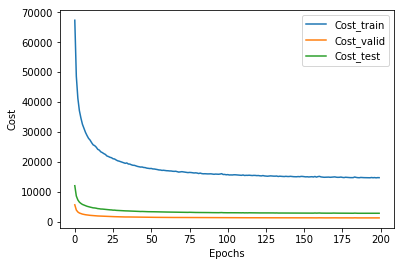

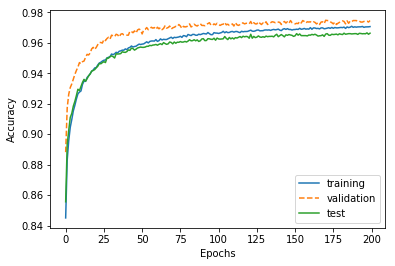

In [24]:

plt.plot(range(nn.epochs), nn.eval_['cost_train'], label = 'Cost_train')
plt.plot(range(nn.epochs), nn.eval_['cost_valid'], label = 'Cost_valid')
plt.plot(range(nn.epochs), nn.eval_['cost_test'], label = 'Cost_test')

plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.legend()
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
plt.plot(range(nn.epochs), nn.eval_['test_acc'], 
         label='test')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.savefig('images/12_08.png', dpi=300)
plt.show()

This is the practice run of the Mnist Data. The cost function is already converging to an asymptote at epochs around 75s and accuracy is already near the asymptote at 100 epochs with the number of hidden state to be 10. Thus, for the main run, epoch 100 and hidden state 10 should be sufficient to compare data across the different conditions. 

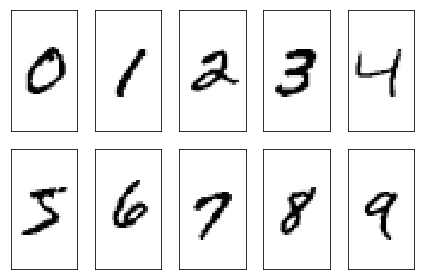

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_5.png', dpi=300)
plt.show()

100/100 | Cost: 26515.00 | Train/Valid Acc.: 92.75%/93.26%  

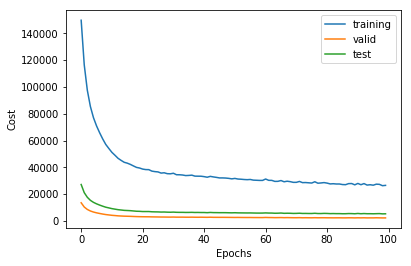

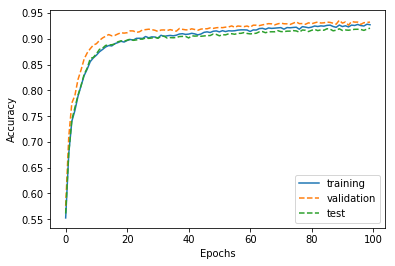

the accuracy of the test data given batchSize : 1, L2 : 0.000000
0.9208


100/100 | Cost: 151705.70 | Train/Valid Acc.: 52.24%/54.60% 

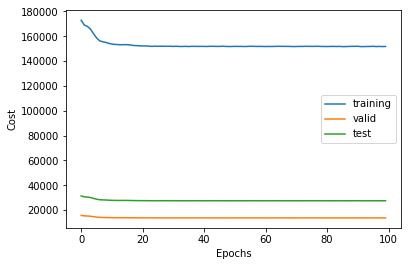

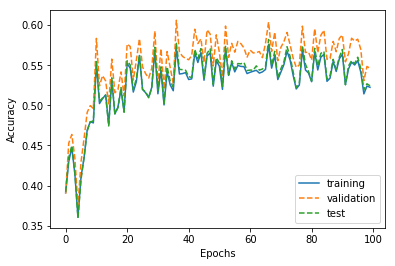

the accuracy of the test data given batchSize : 1, L2 : 0.100000
0.5243


100/100 | Cost: 65003.77 | Train/Valid Acc.: 88.98%/91.46%  

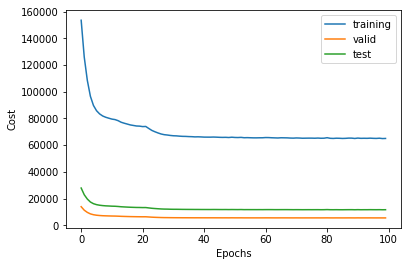

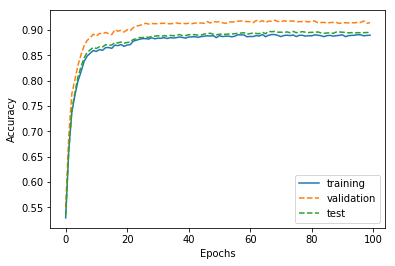

the accuracy of the test data given batchSize : 1, L2 : 0.010000
0.8955


100/100 | Cost: 32284.91 | Train/Valid Acc.: 92.19%/93.30%  

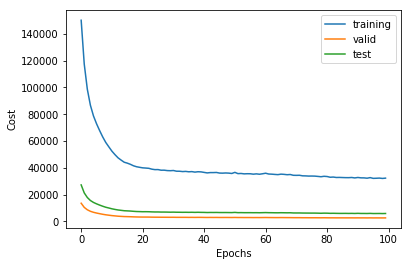

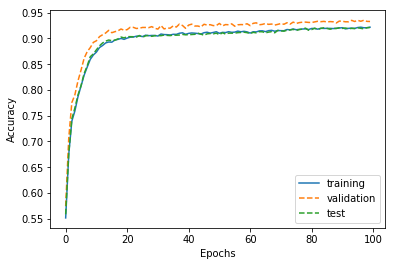

the accuracy of the test data given batchSize : 1, L2 : 0.001000
0.9214


100/100 | Cost: 26749.12 | Train/Valid Acc.: 92.71%/92.90%  

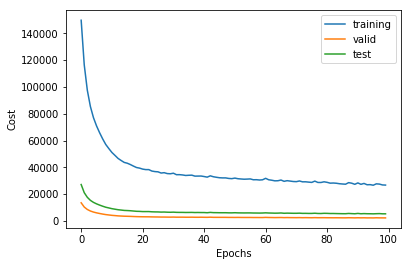

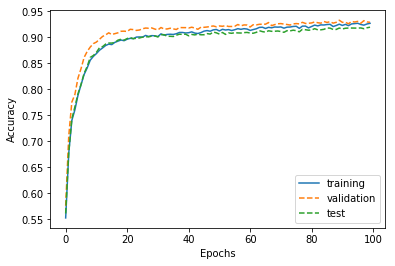

the accuracy of the test data given batchSize : 1, L2 : 0.000000
0.9196


100/100 | Cost: 65012.67 | Train/Valid Acc.: 88.96%/91.48%  

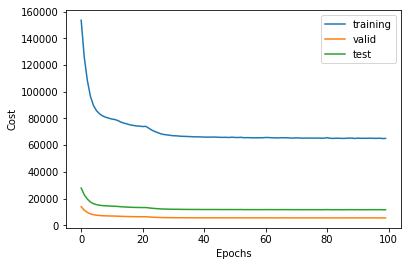

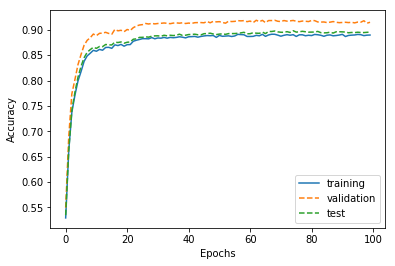

the accuracy of the test data given batchSize : 1, L2 : 0.100000
0.8954


100/100 | Cost: 32205.21 | Train/Valid Acc.: 92.20%/93.14%  

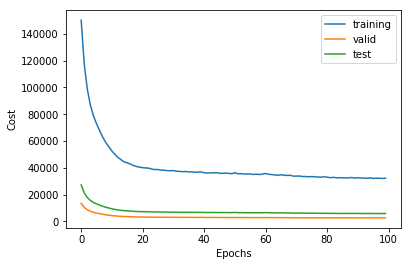

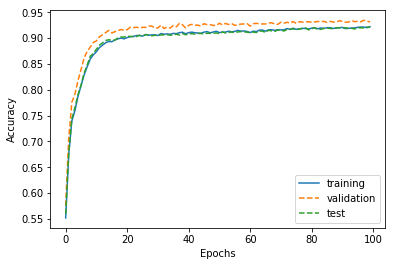

the accuracy of the test data given batchSize : 1, L2 : 0.010000
0.9209


100/100 | Cost: 26982.11 | Train/Valid Acc.: 92.76%/92.94%  

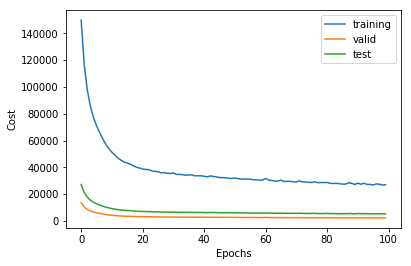

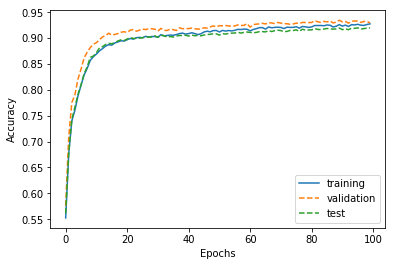

the accuracy of the test data given batchSize : 1, L2 : 0.001000
0.9197


100/100 | Cost: 28158.71 | Train/Valid Acc.: 92.52%/92.96%  

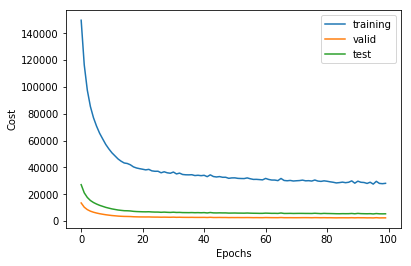

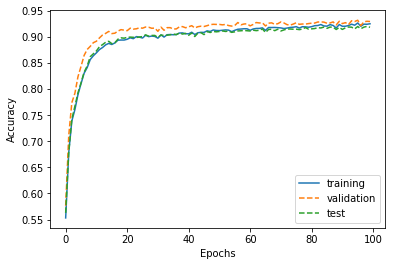

the accuracy of the test data given batchSize : 1, L2 : 0.000000
0.9185


100/100 | Cost: 32728.95 | Train/Valid Acc.: 92.01%/93.32%  

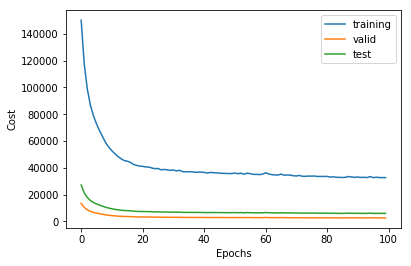

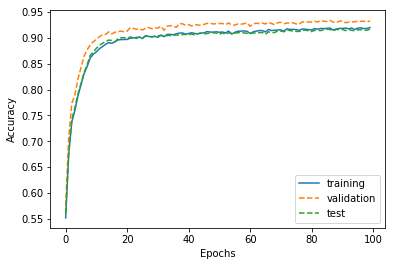

the accuracy of the test data given batchSize : 1, L2 : 0.100000
0.9171


100/100 | Cost: 27739.60 | Train/Valid Acc.: 92.71%/93.46%  

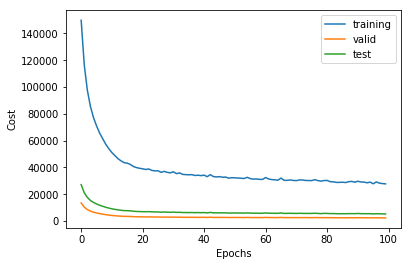

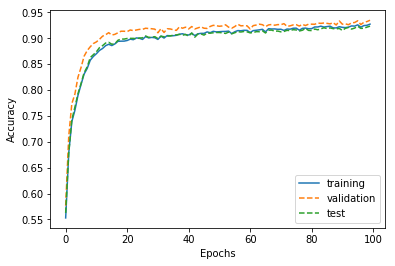

the accuracy of the test data given batchSize : 1, L2 : 0.010000
0.9232


100/100 | Cost: 28179.63 | Train/Valid Acc.: 92.55%/92.96%  

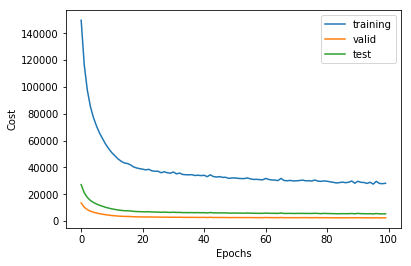

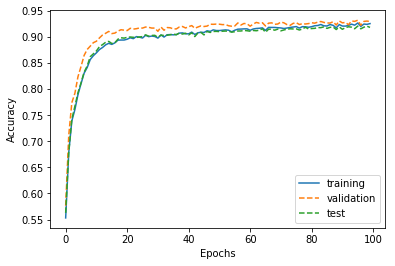

the accuracy of the test data given batchSize : 1, L2 : 0.001000
0.9183


100/100 | Cost: 31852.11 | Train/Valid Acc.: 91.26%/92.50%  

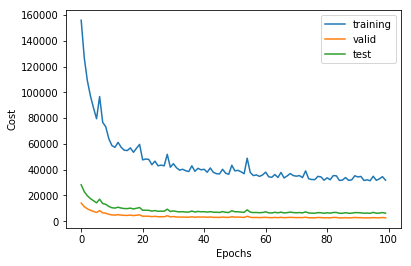

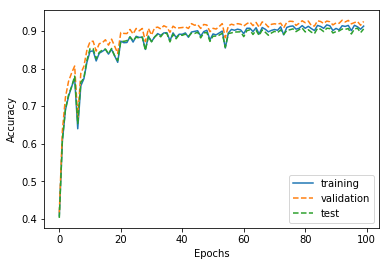

the accuracy of the test data given batchSize : 1, L2 : 0.000000
0.905


100/100 | Cost: 32719.09 | Train/Valid Acc.: 91.11%/92.24%  

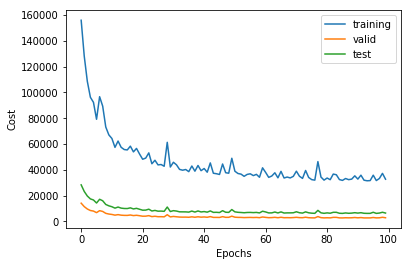

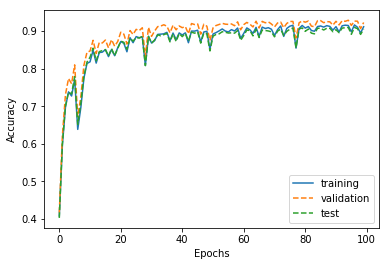

the accuracy of the test data given batchSize : 1, L2 : 0.100000
0.9045


100/100 | Cost: 32324.44 | Train/Valid Acc.: 91.07%/92.20%  

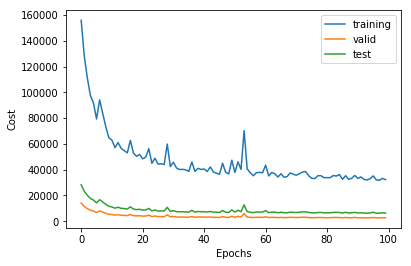

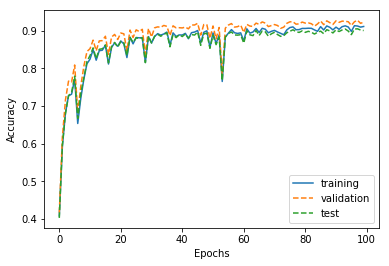

the accuracy of the test data given batchSize : 1, L2 : 0.010000
0.8999


100/100 | Cost: 32055.10 | Train/Valid Acc.: 91.21%/92.40%  

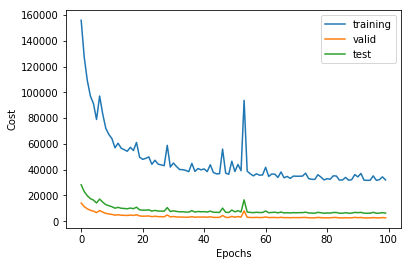

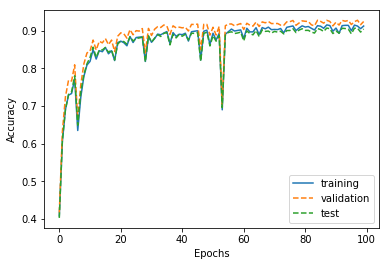

the accuracy of the test data given batchSize : 1, L2 : 0.001000
0.9041


100/100 | Cost: 178930.58 | Train/Valid Acc.: 11.29%/10.60% 

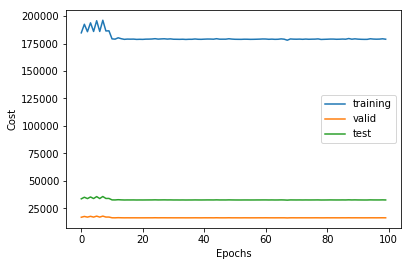

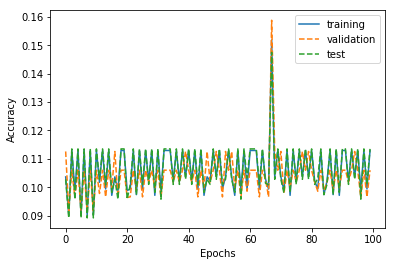

the accuracy of the test data given batchSize : 1, L2 : 0.000000
0.1135


100/100 | Cost: 178979.37 | Train/Valid Acc.: 11.29%/10.60% 

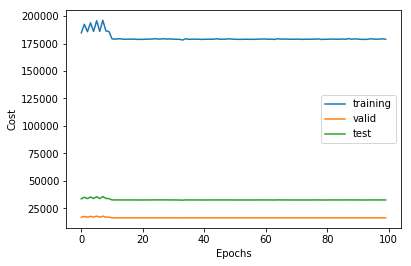

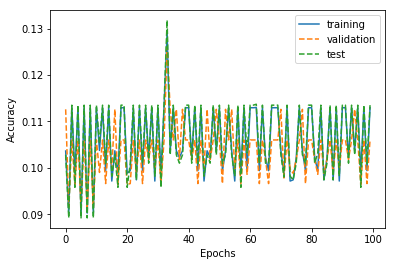

the accuracy of the test data given batchSize : 1, L2 : 0.100000
0.1135


100/100 | Cost: 178935.88 | Train/Valid Acc.: 11.29%/10.60% 

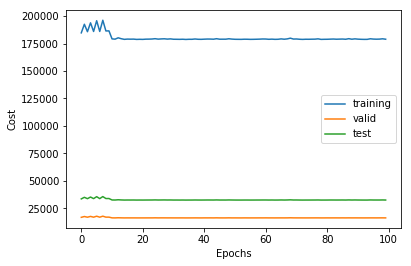

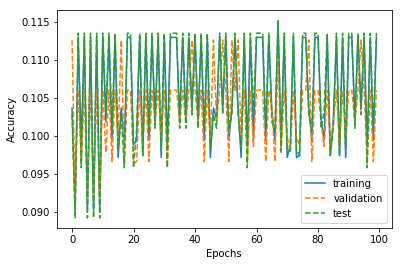

the accuracy of the test data given batchSize : 1, L2 : 0.010000
0.1135


100/100 | Cost: 178931.15 | Train/Valid Acc.: 11.29%/10.60% 

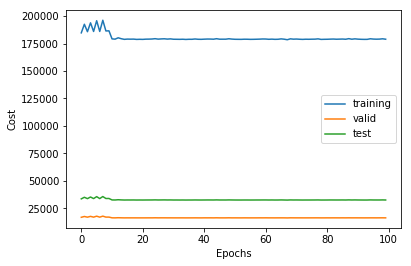

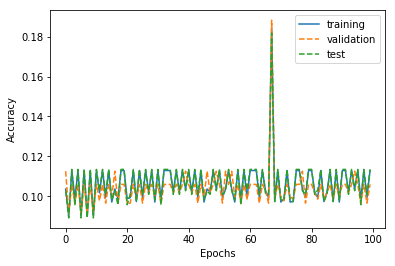

the accuracy of the test data given batchSize : 1, L2 : 0.001000
0.1135


100/100 | Cost: 3679795.10 | Train/Valid Acc.: 10.22%/10.18% 

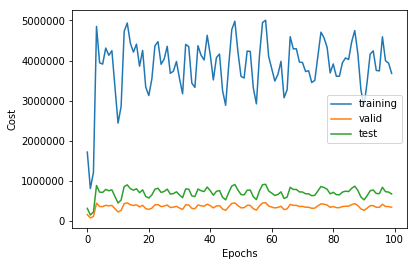

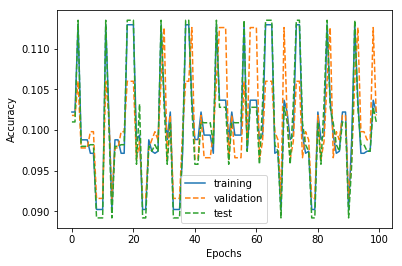

the accuracy of the test data given batchSize : 1, L2 : 0.000000
0.101


100/100 | Cost: 3385606.56 | Train/Valid Acc.: 10.37%/11.26% 

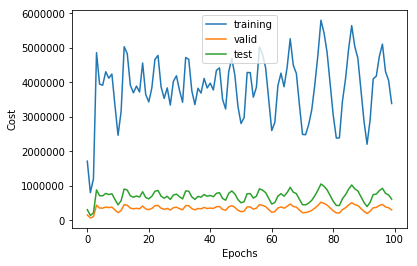

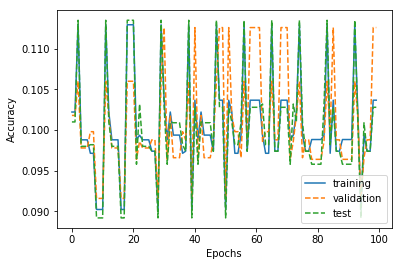

the accuracy of the test data given batchSize : 1, L2 : 0.100000
0.1028


100/100 | Cost: 4027915.43 | Train/Valid Acc.: 11.29%/10.60% 

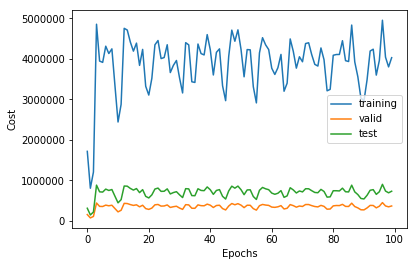

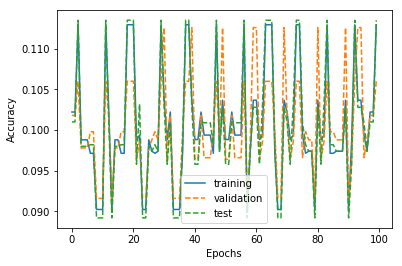

the accuracy of the test data given batchSize : 1, L2 : 0.010000
0.1135


100/100 | Cost: 2829916.83 | Train/Valid Acc.: 10.22%/10.18% 

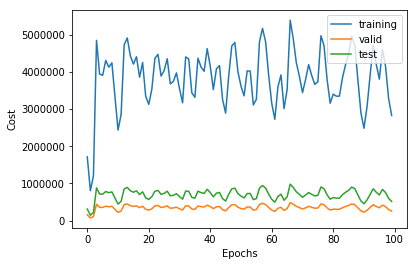

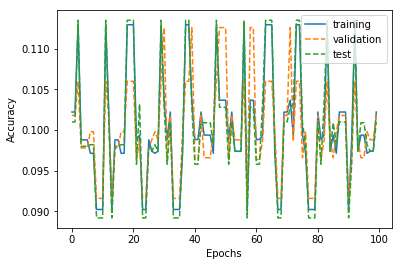

the accuracy of the test data given batchSize : 1, L2 : 0.001000
0.101


In [25]:
batchSizeList = [1, 10, 100, 1000, 10000, 55000]
L2List = [0, 0.1, 0.01, 0.001]
accuracys = []


for batchSizes in batchSizeList:
    for L2s in L2List:
        nn = NeuralNetMLP(n_hidden=10, 
                  l2=L2s, 
                  epochs=100, 
                  eta=0.0005,
                  minibatch_size=batchSizes, 
                  shuffle=True,
                  seed=1)
        
        nn.fit(X_train=X_train[:55000],
               y_train=y_train[:55000],
               X_valid=X_train[55000:],
               y_valid=y_train[55000:],
              X_test = X_test,
              y_test = y_test)
        plt.plot(range(nn.epochs), nn.eval_['cost_train'], label ='training')
        plt.plot(range(nn.epochs), nn.eval_['cost_valid'], label ='valid')
        plt.plot(range(nn.epochs), nn.eval_['cost_test'], label ='test')
        plt.legend()
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        #plt.savefig('images/12_07.png', dpi=300)
        plt.show()

        plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
                 label='training')
        plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
                 label='validation', linestyle='--')
        plt.plot(range(nn.epochs), nn.eval_['test_acc'], 
                 label='test', linestyle='--')

        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend()
        #plt.savefig('images/12_08.png', dpi=300)
        plt.show()
        
        y_pred = nn.predict(X_test)
        print_result = "the accuracy of the test data given batchSize : %d, L2 : %f" % (batchSizes, L2s)
        print(print_result)
        accuracys.append(np.mean(y_pred == y_test))
        print(np.mean(y_pred == y_test))

In [35]:
print('test accuracy')
print(accuracys)
print('highest test accuracy index')
print(np.argmax(accuracys))
print('hihest test accuracy')
print(max(accuracys))



test accuracy
[0.9208, 0.5243, 0.8955, 0.9214, 0.9196, 0.8954, 0.9209, 0.9197, 0.9185, 0.9171, 0.9232, 0.9183, 0.905, 0.9045, 0.8999, 0.9041, 0.1135, 0.1135, 0.1135, 0.1135, 0.101, 0.1028, 0.1135, 0.101]
highest test accuracy index
10
hihest test accuracy
0.9232


The accuracy was highest when the batchsize was 100 with L2 of .01. Unfortunately, there was a typo in the codes above and the batchsize of all print-out to be 1. However, as the data shown, the batchsize was applied with ascending order, starting from 1 to 55000. Upto batchsize of 1000, the multilayer perceptron learned significantly well; however, after 1000, the machine only correct at the chance level of 10%. As shown in the graph, upto 1000, cost function converged to an asymptote, but after 1000, cost function was flat suggesting no learning. 

In [28]:
#re-run the best one

nn = NeuralNetMLP(n_hidden=10, 
          l2=0.01, 
          epochs=100, 
          eta=0.0005,
          minibatch_size=100, 
          shuffle=True,
          seed=1)

nn.fit(X_train=X_train[:55000],
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:],
       X_test = X_test,
       y_test = y_test)



100/100 | Cost: 27739.60 | Train/Valid Acc.: 92.71%/93.46%  

Test accuracy: 92.32%


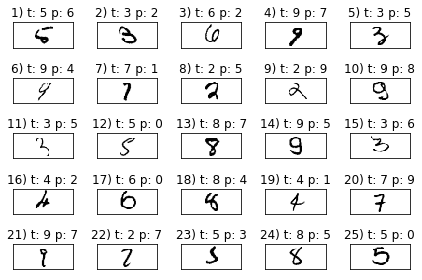

In [36]:
y_test_pred = nn.predict(X_test)

acc = (np.sum(y_test == y_test_pred)

       .astype(np.float) / X_test.shape[0])



print('Test accuracy: %.2f%%' % (acc * 100))

miscl_img = X_test[y_test != y_test_pred][:25]

correct_lab = y_test[y_test != y_test_pred][:25]

miscl_lab = y_test_pred[y_test != y_test_pred][:25]



fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)

ax = ax.flatten()

for i in range(25):

    img = miscl_img[i].reshape(28, 28)

    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))



ax[0].set_xticks([])

ax[0].set_yticks([])

plt.tight_layout()

#plt.savefig('images/12_09.png', dpi=300)

plt.show()

Except few occasions, (e.g. 7), 10), and 17)) it seems unclear why they are wrongly classfied. So, The number of hidden state and epochs were set at 100 and 200 respectively and rerun in the next. 

In [39]:
#re-run the best one

nn = NeuralNetMLP(n_hidden=100, 
          l2=0.01, 
          epochs=200, 
          eta=0.0005,
          minibatch_size=100, 
          shuffle=True,
          seed=1)

nn.fit(X_train=X_train[:55000],
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:],
       X_test = X_test,
       y_test = y_test)

200/200 | Cost: 5065.78 | Train/Valid Acc.: 99.28%/97.98%  

Test accuracy: 97.54%


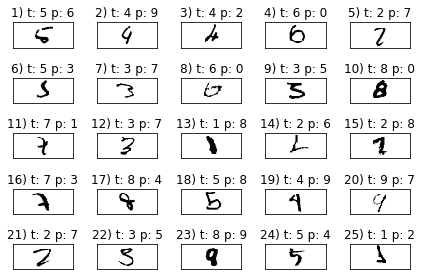

In [40]:
y_test_pred = nn.predict(X_test)

acc = (np.sum(y_test == y_test_pred)

       .astype(np.float) / X_test.shape[0])



print('Test accuracy: %.2f%%' % (acc * 100))

miscl_img = X_test[y_test != y_test_pred][:25]

correct_lab = y_test[y_test != y_test_pred][:25]

miscl_lab = y_test_pred[y_test != y_test_pred][:25]



fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)

ax = ax.flatten()

for i in range(25):

    img = miscl_img[i].reshape(28, 28)

    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))



ax[0].set_xticks([])

ax[0].set_yticks([])

plt.tight_layout()

#plt.savefig('images/12_09.png', dpi=300)

plt.show()

Increasing the number of epochs and hidden state slightly increased the test performance, from 92% to 97.5%.The misclassfied result is more reasonable. 